# Getting started with Regym

This notebook will illustrate some basic workflow that can be achieved with the `regym` framework. This is not an exhaustive list.

The workflow of a (single agent) Reinforcement Learning experiment normally goes as follows:
1. An environment is selected
2. An agent fit for observing and acting in the environment is generated.
3. For a given number of episodes, the agent collects information from its interaction with the environment. These interactions are used to change the agent's policy by using a Reinforcement Learning algorithm. 
4. A trail of episode trajectories are generated by the agent, which can be used to meassure its performance.

### Step 1: generating an environment

In order to select an environment, we only need to import the `generate_task` function inside the `regym.environments` submodule. This function takes a single argument which can be:

1. The name of an OpenAI Gym environment locally installed in your system (i.e, it can be created via `gym.make(environment_name)`
2. Relative path to a Unity executable which was compiled using Unity ML-Agents

For this tutorial, let's use the iconic Cart Pole environment.

In [48]:
from regym.environments import generate_task

task = generate_task('CartPole-v0')

In [49]:
print(task)

Task(name='CartPole-v0', env=<TimeLimit<CartPoleEnv<CartPole-v0>>>, state_space_size=None, action_space_size=None, observation_dim=4, observation_type='Continuous', action_dim=2, action_type='Discrete', hash_function=None)


A task is a wrapper around an OpenAI Gym compliant environment. Under the hood, `regym` parses information from the underlying environment. This information will be used to initialize the agents that will be used to act in the task's environment. Having this layer of abstraction allows us to treat OpenAI Gym and Unity environments equally. The most important elements of a task are:

1. `task.env`: The environment where the agents will act, it MUST comply with the OpenAI Gym interface.
2. `task.observation_type` and `task.action_type`: Both of which can be either `Discrete` or `Continuous`. Certain algorithms cannot be used in continuous scenarios, or they require certain changes to be made. By parsing the environment we can find out what kind of observation and action spaces we will have to work with. But all of this is done for you!

### Step 2: building an agent

Now that we have specified what task we want to solve, we need to create an agent that is able to solve it. 

There are many possible agents that we can create to solve the task above. the submodule `regym.rl_algorithms` imports a set of functions, implemented by all agents in our framework, with the signature: `build_X_Agent(task, config, agent_name)`. This function takes three arguments:

1. The task that needs solving. From this task, the agent will figure out the input and output size of the    corresponding layers of the neural net representing the agent's policy or value networks. Different tasks (e.g tasks with discrete / continuous action spaces) require different neural network topologies.
2.    Config is a dictionary containing keyword - value pairs of the algorithm's hyperparameters. **Refer to source code for a list of relevant hyper parameters for each algorithm / agent**.
3.    The agent name gives a string ID, nothing fancy.

For this example we will use `build_PPO_Agent` to create an agent that gathers experience from the environment and uses Proximal Policy Optimization to change the agent's policy. Note that we could have choosen from any other of the (non-tabular) implemented algorithm, such as `build_DQN_Agent` or `build_A2C_Agent` functions. 

In [50]:
from regym.rl_algorithms import build_PPO_Agent

In [51]:
# Hyper parameters for our PPO agent
def ppo_config_dict():
     config = dict()
     config['discount'] = 0.99
     config['use_gae'] = True
     config['use_cuda'] = False
     config['gae_tau'] = 0.95
     config['entropy_weight'] = 0.01
     config['gradient_clip'] = 5
     config['optimization_epochs'] = 10
     config['mini_batch_size'] = 256
     config['ppo_ratio_clip'] = 0.2
     config['learning_rate'] = 3.0e-4
     config['adam_eps'] = 1.0e-5
     config['horizon'] = 128
     config['phi_arch'] = 'MLP'
     config['actor_arch'] = 'None'
     config['critic_arch'] = 'None'
     return config

In [52]:
config = ppo_config_dict()
agent = build_PPO_Agent(task, config, "Cool-ProximalPolicyOptimization")

### Step 3: training the agent

![rl-loop](https://proxy.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.kdnuggets.com%2Fwp-content%2Fuploads%2Fiot-agent-feedback-loop.jpg&f=1)

Now we have both a `task` and an `agent` to solve it. The only step left is to let the agent train in the environment held by the task. Luckily, the submodule `regym.rl_loops` features both single agent and multiagent loops. The most basic unit of training is an episode. An `agent` can be trained for single episode in a given `task` by invoking the `run_episode(environment, agent, training=True)` function. This function will return a list containing the trajectory experienced by the agent, that is, a list of tuples`[(observation, action, reward, successive_observation, done_flag)...]`

In [53]:
from regym.rl_loops.singleagent_loops.rl_loop import run_episode
from tqdm import tqdm

training_episodes = 3000
# This will take a while
training_trajectories = [run_episode(task.env, agent, training=True) for _ in tqdm(range(training_episodes))]
task.env.close()

100%|██████████| 3000/3000 [03:46<00:00,  7.31it/s]


### Step 4: Plot learning

In the `CartPole-v0` environment, each step gives a reward of `1.0`, which means that the length of an episode is positively correlated to how well an agent performed in it. We can plot the length of each trajectory (y axis) against the iteration number of such trajectory (x axis).

In [54]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

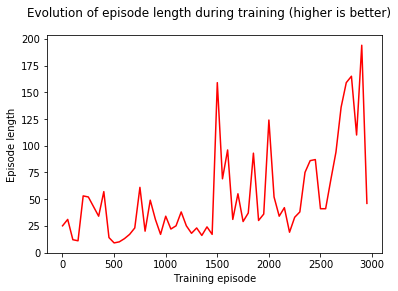

In [55]:
def plot_episode_length_over_trajectories(trajectories):
    xs = [i + 1 for i in range(len(trajectories))]
    ys = [len(trajectory) for trajectory in trajectories]
    xs_subsampled, ys_subsampled = xs[::50], ys[::50]
    plt.xlabel("Training episode")
    plt.ylabel("Episode length")
    plt.suptitle("Evolution of episode length during training (higher is better)")
    plt.plot(xs_subsampled, ys_subsampled, 'r-')
    
plot_episode_length_over_trajectories(training_trajectories)

We can see that this (very noisy) graph shows an upward curve, meaning that the agent keeps improving it's policy, which at the beginning had only survived for ~50 steps, but as training progreses, the average episode length also increases. 

And we are done!

In this notebook we've shown how to:
1. Create a task fit to be used by the agents that can be created in this framework
2. Generated an agent given a task and a dictionary of hyperparameters
3. Trained the agent in the given task and how to process the trajectories generated by the agent in the task's environment

**All of this was done with less than 10 lines of code!**